In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [ ]:
# Step 1: Download Data
data = yf.download(['INFY.NS', 'TCS.NS'], start='2020-01-01', end='2025-04-08')['Close']
data.columns = ['INFY', 'TCS']
data.dropna(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


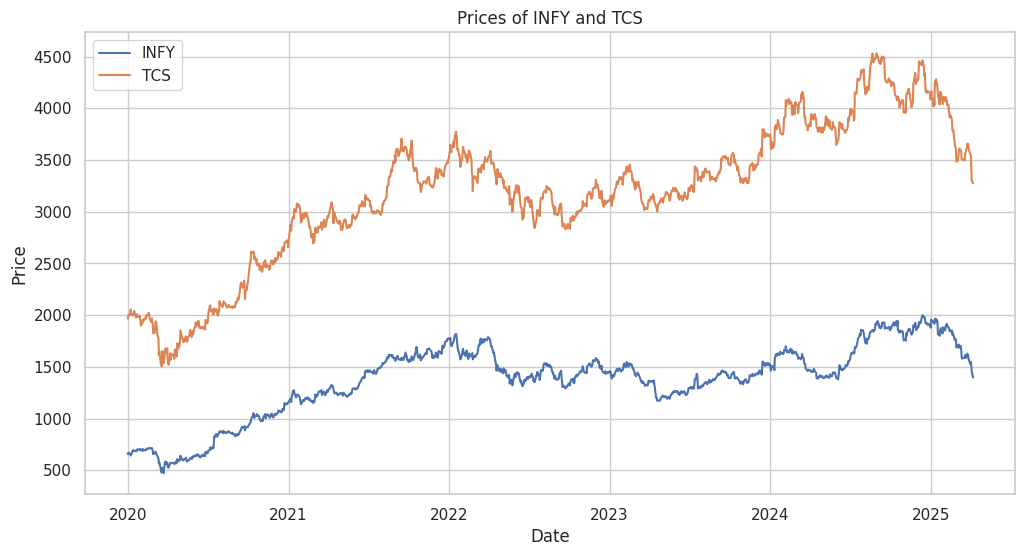

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['INFY'], label='INFY')
plt.plot(data['TCS'], label='TCS')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Prices of INFY and TCS')
plt.legend()
plt.show()


In [ ]:
# Step 2: ADF Tests - Check Stationarity
def adf_test(series, name):
    result = adfuller(series)
    print(f"\nADF Test for {name}:")
    print(f"  Test Statistic = {result[0]:.4f}")
    print(f"  p-value = {result[1]:.4f}")
    print("  Stationary?" , "Yes" if result[1] < 0.05 else "No")

adf_test(data['INFY'], 'Infosys')
adf_test(data['TCS'], 'TCS')
adf_test(data['INFY'].diff().dropna(), 'Δ Infosys')
adf_test(data['TCS'].diff().dropna(), 'Δ TCS')


ADF Test for Infosys:
  Test Statistic = -2.0866
  p-value = 0.2499
  Stationary? No

ADF Test for TCS:
  Test Statistic = -1.8697
  p-value = 0.3465
  Stationary? No

ADF Test for Δ Infosys:
  Test Statistic = -34.5802
  p-value = 0.0000
  Stationary? Yes

ADF Test for Δ TCS:
  Test Statistic = -35.5488
  p-value = 0.0000
  Stationary? Yes


In [ ]:
# Step 3: Long-run regression: INFY ~ TCS
model_lr = sm.OLS(data['INFY'], sm.add_constant(data['TCS'])).fit()
residuals = model_lr.resid
adf_test(residuals, 'Residuals (INFY ~ TCS)')


ADF Test for Residuals (INFY ~ TCS):
  Test Statistic = -2.7968
  p-value = 0.0587
  Stationary? No


<Figure size 1000x500 with 0 Axes>

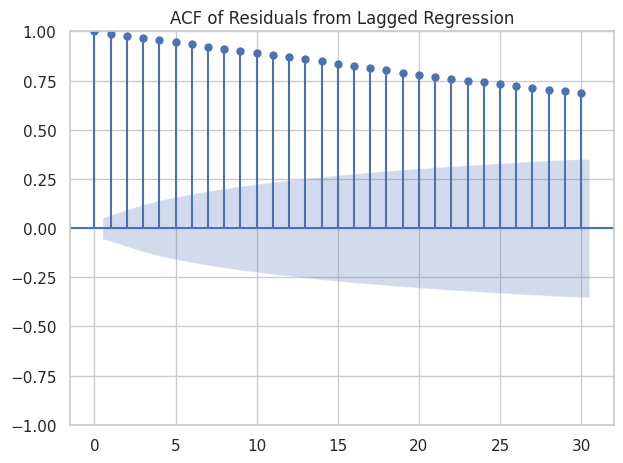

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF of residuals
plt.figure(figsize=(10, 5))
plot_acf(residuals, lags=30)
plt.title("ACF of Residuals from Lagged Regression")
plt.tight_layout()
plt.show()

In [ ]:
data.head()

,INFY,TCS
Date,,
2020-01-01,661.205200,1975.343140
2020-01-02,659.275940,1966.275024
2020-01-03,669.415894,2005.461182
2020-01-06,662.999756,2005.279175
2020-01-07,653.174011,2010.200684


In [ ]:
# Step 4: Add one lag to each variable if residuals not stationary
df_lagged = pd.DataFrame({
    'Y_t': data['INFY'][1:],
    'Y_t_1': data['INFY'].shift(1)[1:],
    'X_t': data['TCS'][1:],
    'X_t_1': data['TCS'].shift(1)[1:]
}).dropna()

X = sm.add_constant(df_lagged[['Y_t_1', 'X_t', 'X_t_1']])
model_lagged = sm.OLS(df_lagged['Y_t'], X).fit()
print(model_lagged.summary())

resid_lagged = model_lagged.resid
adf_test(resid_lagged, 'Residuals from Lagged Regression')

                            OLS Regression Results                            
Dep. Variable:                    Y_t   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 2.022e+05
Date:                Sun, 13 Apr 2025   Prob (F-statistic):               0.00
Time:                        14:44:16   Log-Likelihood:                -5471.7
No. Observations:                1304   AIC:                         1.095e+04
Df Residuals:                    1300   BIC:                         1.097e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8534      2.232     -0.382      0.7

<Figure size 1000x500 with 0 Axes>

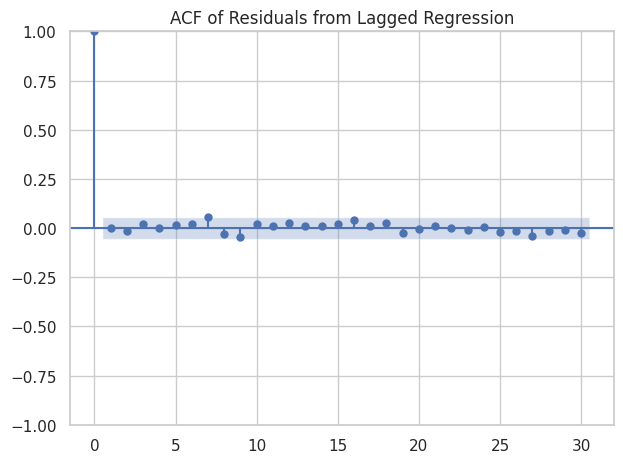

In [ ]:
# Plot ACF of residuals from lagged regression
plt.figure(figsize=(10, 5))
plot_acf(resid_lagged, lags=30)
plt.title("ACF of Residuals from Lagged Regression")
plt.tight_layout()
plt.show()

# ECM Construction

In [ ]:
# Step 5: build ECM
data['dINFY'] = data['INFY'].diff()
data['dTCS'] = data['TCS'].diff()
data['residual'] = np.nan
data.loc[residuals.index, 'residual'] = residuals
data['residuals'] = data['residual'].shift(1)

# Drop NaNs
ecm_df = data.dropna()

# ECM model
ecm_model = sm.OLS(ecm_df['dINFY'], sm.add_constant(ecm_df[['dTCS', 'residuals']])).fit()
print("\nError Correction Model Results:")
print(ecm_model.summary())


Error Correction Model Results:
                            OLS Regression Results                            
Dep. Variable:                  dINFY   R-squared:                       0.480
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                     599.8
Date:                Sun, 13 Apr 2025   Prob (F-statistic):          2.54e-185
Time:                        14:44:27   Log-Likelihood:                -5471.7
No. Observations:                1304   AIC:                         1.095e+04
Df Residuals:                    1301   BIC:                         1.096e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.22